## Load the data

In [1]:
# import library
import pandas as pd

# Loading dataset
df = pd.read_table('train_preprocess.tsv.txt', delimiter='\t', names=['txt', 'label'])
df.sample(5)

,txt,label
7639,"tertulusan mu untuk kebaikan negeri ini , itul...",positive
10224,handphone samsung milik ku benar-benar bagus d...,positive
8049,"gampang marah kalau pakai indosat , di kota be...",negative
2098,penawaran spesial untuk charm bodyfit super sl...,neutral
9230,santai,positive


In [2]:
# checking for missing values
df.isnull().values.any()

False

In [3]:
# inspect the Dataframe
print(df.shape)
print(df.describe())
print(df.label.value_counts())

(11000, 2)
          txt     label
count   11000     11000
unique  10933         3
top     kesal  positive
freq        4      6416
label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64


## Data Prerpocessing

In [4]:

# upon change text, clean punctuation mark use regrex
import re
def cleansing(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r'[^a-zA-Z]', ' ',text)
    text = re.sub(r'[^\w\s]', '',text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ',text)
    text = re.sub(r'\s+', ' ',text)
    text = re.sub(r'rt @\w+:',' ',text)
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|([#@]\S+)|user|\n|\t', ' ', text)
    return text

df['text_clean'] = df['txt'].apply(cleansing)
df.sample(5)

,txt,label,text_clean
9660,"jalan-jalan ke bandung , terus mau ke tangkuba...",positive,jalan jalan ke bandung terus mau ke tangkuban ...
6932,ppp sebut ada pihak ingin gagalkan ridwan kami...,neutral,ppp sebut ada pihak ingin gagalkan ridwan kami...
10502,"saya sependapat , acara tersebut harus dilenya...",negative,saya sependapat acara tersebut harus dilenyapk...
8147,pasangan wardan - su tidak hadiri konferensi p...,neutral,pasangan wardan su tidak hadiri konferensi per...
3556,tempat ini menyediakan makanan dan minuman yan...,positive,tempat ini menyediakan makanan dan minuman yan...


In [5]:
# define label sentimen and save ke sebuah variable
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


## Feature Extraction

In [6]:
import sklearn as sk
import math

In [7]:
# feature extraction with metode TF-IDF (inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfVectorizer

total_data = df['text_clean'].tolist()

# Proses Feature Extraction
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(total_data)

X = tfidf_vect.fit_transform(total_data)
print("Feature Extraction selesai")

Feature Extraction selesai


In [8]:
tfidf_vect

TfidfVectorizer()

In [11]:
# import and save to pickle
import pickle

with open('tfidf_vect.pkl', 'wb') as f:
    pickle.dump(tfidf_vect, f)

In [13]:
with open('tfidf_vect.pkl', 'rb') as f:
    prepro = pickle.load(f)

In [14]:
list_word = tfidf_vect.get_feature_names_out()
len(list_word)

16790

In [15]:
X = tfidf_vect.transform(total_data)
X

<11000x16790 sparse matrix of type '<class 'numpy.float64'>'
	with 267262 stored elements in Compressed Sparse Row format>

## Train Test split

In [16]:
# split dataset 80 data & 20 data uji for training dan testing
from sklearn.model_selection import train_test_split

y = df.label
y

0        positive
1         neutral
2        positive
3        positive
4        negative
           ...   
10995    positive
10996    positive
10997     neutral
10998    negative
10999    positive
Name: label, Length: 11000, dtype: object

In [17]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
   
print(f"X_Train size: {X_train.shape[0]}")
print(f"y_train size: {y_train.shape[0]}")
print(f"X_test size: {X_test.shape[0]}")
print(f"y_test size: {y_test.shape[0]}")

X_Train size: 8800
y_train size: 8800
X_test size: 2200
y_test size: 2200


In [18]:
pd.Series(y_train).value_counts()

label
positive    5135
negative    2756
neutral      909
Name: count, dtype: int64

In [19]:
pd.Series(y_test).value_counts()

label
positive    1281
negative     680
neutral      239
Name: count, dtype: int64

## Model Training

In [20]:
# metode training with neural network use modul MLPClassifier from library SKlearn

from sklearn.neural_network import MLPClassifier, MLPRegressor

# Initialize model

model = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=300, random_state=1)

# Training

model.fit(X_train, y_train)
print("Training selesai")

Training selesai


In [21]:
# save to pickle
with open('neural_network_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [22]:
# Load Model
with open('neural_network_model.pkl', 'rb') as file:
    model = pickle.load(file)

## Model Evaluation

In [23]:
# evaluation yang di pakai dari SKlearn untuk melakukan evaluasi "classification_report"

from sklearn.metrics import classification_report

test = model.predict(X_test)

print("Testing selesai")

print(classification_report(y_test, test, zero_division=0))

Testing selesai
              precision    recall  f1-score   support

    negative       0.79      0.79      0.79       680
     neutral       0.88      0.68      0.76       239
    positive       0.87      0.91      0.89      1281

    accuracy                           0.85      2200
   macro avg       0.85      0.79      0.81      2200
weighted avg       0.85      0.85      0.85      2200



## Cross validation

In [24]:
# menguji model yang sudah kita buat (cross-validation)
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# KFold divides all the samples in k groups of samples
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

y = y

for iteration, data in enumerate(kf.split(X), start=1):
    
    data_train = X[data[0]]
    target_train = y[data[0]]
    
    data_test = X[data[1]]
    target_test = y[data[1]]
    
    clf = MLPClassifier(random_state=1, max_iter=300)
    clf.fit(data_train, target_train)
    
    preds = clf.predict(data_test)
    
    accuracy = accuracy_score(target_test,preds)
    
    
    print("Training ke-", iteration)
    print(classification_report(target_test,preds, zero_division=0))
    print("========================================================")

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Training ke- 1
              precision    recall  f1-score   support

    negative       0.78      0.78      0.78       680
     neutral       0.83      0.70      0.76       239
    positive       0.87      0.89      0.88      1281

    accuracy                           0.84      2200
   macro avg       0.82      0.79      0.81      2200
weighted avg       0.84      0.84      0.84      2200

Training ke- 2
              precision    recall  f1-score   support

    negative       0.79      0.75      0.77       706
     neutral       0.74      0.71      0.73       220
    positive       0.87      0.91      0.89      1274

    accuracy                           0.84      2200
   macro avg       0.80      0.79      0.80      2200
weighted avg       0.83      0.84      0.83      2200

Training ke- 3
              precision    recall  f1-score   support

    negative       0.79      0.77      0.78       682
     neutral       0.82      0.73      0.77       215
    positive       0.88      0

## Model Predict

In [25]:
original_text = '''
rasa syukur, cukup.
'''

text = prepro.transform([cleansing(original_text)])

result = model.predict(text)[0]
print(f"text: {original_text}\nSentiment:", result)

text: 
rasa syukur, cukup.

Sentiment: positive


In [26]:
!pip install mlxtend

     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     --- ------------------------------------ 0.1/1.4 MB 2.2 MB/s eta 0:00:01
     ---- ----------------------------------- 0.2/1.4 MB 1.5 MB/s eta 0:00:01
     ------ --------------------------------- 0.2/1.4 MB 1.7 MB/s eta 0:00:01
     ------ --------------------------------- 0.2/1.4 MB 1.7 MB/s eta 0:00:01
     -------- ------------------------------- 0.3/1.4 MB 1.2 MB/s eta 0:00:01
     --------- ------------------------------ 0.3/1.4 MB 1.2 MB/s eta 0:00:01
     ---------- ----------------------------- 0.4/1.4 MB 1.1 MB/s eta 0:00:01
     ----------- ---------------------------- 0.4/1.4 MB 1.1 MB/s eta 0:00:01
     ----------- ---------------------------- 0.4/1.4 MB 1.0 MB/s eta 0:00:01
     ------------- -------------------------- 0.5/1.4 MB 1.0 MB/s eta 0:00:01
     --------------- ------------------------ 0.5/1.4 MB 1.0 MB/s eta 0:00:01


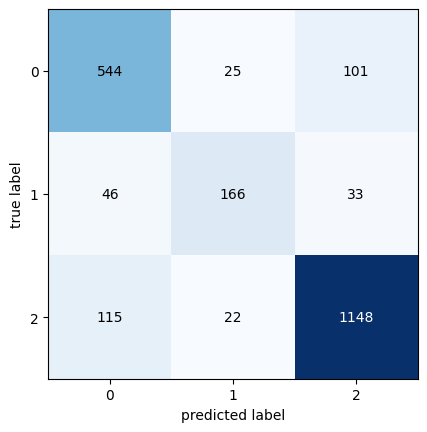

In [28]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(target_test,preds)
plot_confusion_matrix(conf_mat)

plt.show()

In [29]:
# Manual Compare
prediction_data = pd.DataFrame({'True Data':target_test.values.ravel(), 'Prediction':preds})
prediction_data.sample(10)

,True Data,Prediction
664,positive,positive
667,negative,negative
337,negative,negative
723,positive,positive
475,positive,positive
661,negative,negative
375,positive,positive
695,neutral,neutral
705,positive,positive
1787,positive,positive
